In [144]:
import pandas as pd
import numpy as np

import os
import re

# get the list of files and directories in the raw data  directory
directory = 'Data/text_files/'
text_files = os.listdir(directory)

data_list = []


# add the data to each sample
for file in text_files:
    data = pd.read_csv(directory+file,delimiter='\t').drop('Unnamed: 6', axis=1)
    data = data[data['freq/Hz']!=0.0]
    data = data.astype({'cycle number': int})
    
    data_list.append(data)
    
    

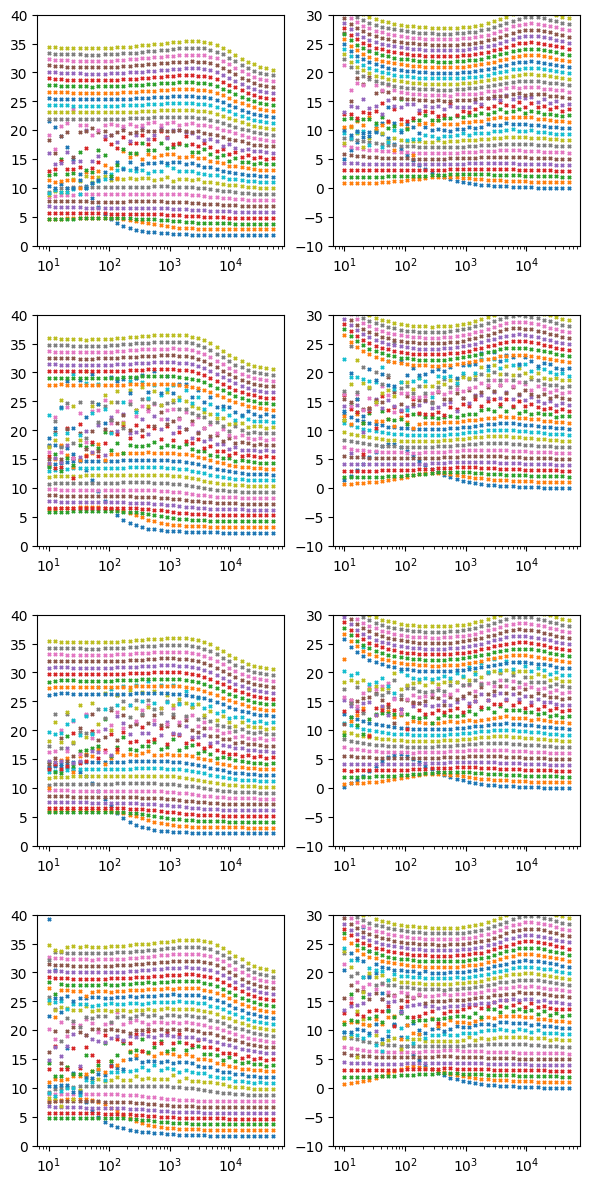

In [145]:
import numpy as np
import matplotlib.pyplot as plt

mm = 0.03937

fig = plt.figure(figsize=(7,12))
subfigs = fig.subfigures(nrows=4,ncols=1)

for row, data in enumerate(data_list):    
    
    subfig = subfigs[row]
    #subfig.suptitle('Sample Serial Number: '+sample_serial_number)
    
    re_ax, im_ax = subfig.subplots(nrows=1, ncols=2)    
    
    re_ax.set_xscale('log')
    im_ax.set_xscale('log')
    
    for cycle in range(data['cycle number'].max()):
        cycle_data = data[data['cycle number'] == cycle+1]
        
        freq = np.array(cycle_data['freq/Hz'])
        ReZ = np.array(cycle_data['Re(Z)/Ohm'])
        ImZ = np.array(cycle_data['-Im(Z)/Ohm'])
        
        re_ax.scatter(freq,ReZ+int(cycle),marker='x',s=5)
        im_ax.scatter(freq,ImZ+int(cycle),marker='x',s=5)
        
        re_ax.set_ylim(0,40)
        im_ax.set_ylim(-10,30)

In [146]:
from scipy.special import hermite

def Gaussian_Func(x,sigma):
    y = np.exp(-x**2/(2*sigma**2)) / (2.5066*sigma)
    return y

def Gaussian_Derivative(x,n,sigma):
    hermite_poly = hermite(n)
    y = (-1)**n * Gaussian_Func(x,sigma) * hermite_poly(x/sigma) * (1/sigma)**n
    return y

In [147]:
def quad(f, a, b, n=5):
    # Generate the quadrature rule coefficients
    x, w = np.polynomial.legendre.leggauss(n)
    
    # Scale the quadrature points and weights to the interval [a, b]
    x_scaled = 0.5 * (b - a) * x + 0.5 * (b + a)
    w_scaled = 0.5 * (b - a) * w
    
    # Evaluate the function at the quadrature points and sum up the weighted contributions
    integral = np.sum(w_scaled[:,None] * f(x_scaled),axis=0)
    
    return integral

def re_integrand(x, fn, fm, gaussian_sigma):
    x_diff = x[:,None] - fn[None,:] + fm[None,:]
    return Gaussian_Func(x, gaussian_sigma)[:,None] / (1 + np.exp(-2 * x_diff))

def im_integrand(x, fn, fm, gaussian_sigma):
    x_diff = x[:,None] - fn[None,:] + fm[None,:]
    return Gaussian_Func(x, gaussian_sigma)[:,None] * np.exp(-x_diff) / (1 + np.exp(-2 * x_diff))

def norm_integrand(x, fn, fm, k, gaussian_sigma):
    x_diff = x[:,None] - fn[None,:] + fm[None,:]
    return Gaussian_Derivative(x_diff,k,gaussian_sigma)*Gaussian_Derivative(x,k,gaussian_sigma)[:,None]

def integrate_test_functions(log_fm,log_fn,gaussian_sigma):

    #Integrate the test functions
    fn_mesh, fm_mesh = np.meshgrid(log_fm, log_fn, indexing='ij')
    
    # reshape fn_mesh and fm_mesh into column vectors
    fn = fn_mesh.flatten()
    fm = fm_mesh.flatten()
    
    #Real integral
    # integral = np.array([quad(lambda y: Gaussian_Func(y,gaussian_sigma)*1/(1+np.exp(-2*(y-fn+fm))), -3*gaussian_sigma, 3*gaussian_sigma) for fn, fm in zip(fn_mesh.flatten(), fm_mesh.flatten())])
    integral = quad(lambda y: re_integrand(y,fn,fm,gaussian_sigma), -3*gaussian_sigma, 3*gaussian_sigma)
                                   
    A_re = integral.reshape(fn_mesh.shape)
    
    #Imag integral
    # integral = np.array([quad(lambda y: Gaussian_Func(y,gaussian_sigma)*np.exp(-(y-fn+fm))/(1+np.exp(-2*(y-fn+fm))), -3*gaussian_sigma, 3*gaussian_sigma) for fn, fm in zip(fn_mesh.flatten(), fm_mesh.flatten())])    
    integral = quad(lambda y: im_integrand(y,fn,fm,gaussian_sigma), -3*gaussian_sigma, 3*gaussian_sigma)
    
    A_im = integral.reshape(fn_mesh.shape)
    
    return A_re, A_im

In [192]:
from scipy.optimize import lsq_linear, minimize

def cost_func(x,f_m,A_re,A_im,b,norm_matrix):
    
    x_re = x[0:A_re.shape[1]]
    x_im = x[A_re.shape[1]:A_re.shape[1]+A_im.shape[1]]
    #x_im = x_re
    R = x[A_re.shape[1]+A_im.shape[1]]
    L = x[A_re.shape[1]+A_im.shape[1]+1]
        
    Z_sim_re = np.matmul(A_re,x_re)+R
    Z_sim_im = np.matmul(A_im,x_im)+np.exp(f_m)*L
    
    Z_exp_re = np.real(b)
    Z_exp_im = np.imag(b)


    
    Re_cost = 1.0*np.linalg.norm((Z_exp_re-Z_sim_re))
    Im_cost = 1.0*np.linalg.norm((Z_exp_im-Z_sim_im))
    Re_norm_cost = (np.matmul(x_re,np.matmul(norm_matrix,x_re.T)))
    Im_norm_cost = (np.matmul(x_im,np.matmul(norm_matrix,x_im.T)))
    soft_const = 1e-3*np.sum(np.exp(x_re)+np.exp(x_im))
    
    cost = Re_cost + Im_cost + Re_norm_cost + Im_norm_cost + soft_const

    return cost

def cost_func_jac(x,f_m,A_re,A_im,b,norm_matrix):
        
    x_re = x[0:A_re.shape[1]]
    x_im = x[A_re.shape[1]:A_re.shape[1]+A_im.shape[1]]
    #x_im = x_re
    R = x[A_re.shape[1]+A_im.shape[1]]
    L = x[A_re.shape[1]+A_im.shape[1]+1]

    Z_sim_re = np.matmul(A_re,x_re)+R
    Z_sim_im = np.matmul(A_im,x_im)+np.exp(f_m)*L

    dZ_sim_re = A_re
    dZ_sim_im = A_im
    
    Z_exp_re = np.real(b)
    Z_exp_im = np.imag(b)

    dRe_cost = -2*np.sum((Z_exp_re-Z_sim_re)[:,None]*A_re,axis = 0)
    dIm_cost = -2*np.sum((Z_exp_im-Z_sim_im)[:,None]*A_im,axis = 0)
    dRe_norm_cost = np.matmul(x_re,norm_matrix)+np.matmul(norm_matrix,x_re.T)
    dIm_norm_cost = np.matmul(x_im,norm_matrix)+np.matmul(norm_matrix,x_im.T)
    dR = -2*np.sum((Z_exp_re-Z_sim_re))
    dL = -2*np.sum(np.exp(f_m)*(Z_exp_im-Z_sim_im))

    dcost = np.concatenate((dRe_cost + dRe_norm_cost + 1e-3*np.exp(x_re), dIm_cost + dIm_norm_cost + 1e-3*np.exp(x_im), dR[None], dL[None]),axis = 0)

    return dcost


def constraint(x):
    return np.min(x)

def DRT_Fit(measured_frequencies, measured_Z, fitting_frequencies, reg_params):
    
    f_m = measured_frequencies
    f_n = fitting_frequencies
    Z_m = measured_Z
       
    reg_order = reg_params.shape[0]
    gaussian_width = (np.max(fitting_frequencies)-np.min(fitting_frequencies))/fitting_frequencies.shape[0]
        
    #Generate parameter array
    #real, imag, resistance, inductance
    x_params = np.zeros((2*fitting_frequencies.shape[0]+2))
    
    #Integrate the test functions wrt the measured frequencies
    A_re, A_im = integrate_test_functions(measured_frequencies, fitting_frequencies, gaussian_width/2.355)
    
    #Calculate the regularization matrix
    fn_mesh, fm_mesh = np.meshgrid(f_n, f_n, indexing='ij')
    
    fn = fn_mesh.flatten()
    fm = fm_mesh.flatten()
    
    M = np.zeros((fitting_frequencies.shape[0],fitting_frequencies.shape[0]))
    for k in range(reg_order):
        integral = quad(lambda y: norm_integrand(y,fn,fm,k,gaussian_width/2.355), -3*gaussian_width/2.355, 3*gaussian_width/2.355)
        M += reg_params[k]*integral.reshape(fn_mesh.shape).T
    
    
    #Fit to experimental data
    b = Z_m
    
    #Solve for parameters
    res = minimize(cost_func,x_params,args=(f_m,A_re,A_im,b,M),method='BFGS',jac=cost_func_jac)
    x_params = res['x']
    
    #Calculate the gamma function coefficients
    x_re = x_params[:fitting_frequencies.shape[0]]
    x_im = x_params[fitting_frequencies.shape[0]:-2]
    #x_im = x_re
    R = x_params[-2]
    L = x_params[-1]
    
    return {'x_re': x_re, 
            'x_im': x_im, 
            'R': R,
            'L': L,
            'A_re': A_re,
            'A_im': A_im,
            'f_m': f_m}

In [193]:
"""Model Fitting"""






import time

output = {}

#Generate regularization hyper-parameter array
reg_params = np.array((1e-9,1e-9,1e-7))

for row, data in enumerate(data_list[0:1]):    

    for cycle in range(cycle_data['cycle number'].max()):
        
        #Load data
        Freq = np.array(cycle_data['freq/Hz'])[:-10]
        ReZ = np.array(cycle_data['Re(Z)/Ohm'])[:-10]
        ImZ = np.array(cycle_data['-Im(Z)/Ohm'])[:-10]
        Z = ReZ + 1j*ImZ

        #PARAMS
        f_min = np.min(Freq)/10
        f_max = np.max(Freq)*10
        fitting_params_per_decade = 8


        #Convert to log frequency
        log_f_min = np.log(f_min)
        log_f_max = np.log(f_max)

        #Generate the fitting test function offsets
        number_of_fitting_params = int(fitting_params_per_decade*(log_f_max-log_f_min))
        log_f_n = np.linspace(log_f_min,log_f_max,number_of_fitting_params)
        gaussian_width = (np.max(log_f_n)-np.min(log_f_n))/log_f_n.shape[0]

        #Convert experimental frequencies to log space
        log_Freq = np.log(Freq)

        cycle_data = data[data['cycle number'] == cycle+1]
        

        
        # start the timer
        start_time = time.time()
        
        output[f'Data {row} Cycle {cycle}'] = DRT_Fit(log_Freq, Z, log_f_n, reg_params)
        output[f'Data {row} Cycle {cycle}']['E'] = np.array(cycle_data['<Ewe>/V'])
        output[f'Data {row} Cycle {cycle}']['I'] = np.array(cycle_data['<I>/mA'])
        output[f'Data {row} Cycle {cycle}']['ReZ'] = ReZ
        output[f'Data {row} Cycle {cycle}']['ImZ'] = ImZ
        

        # end the timer
        end_time = time.time()
        
        # calculate the elapsed time
        elapsed_time = end_time - start_time
        
        # print the elapsed time
        print("Elapsed time: {:.2f} seconds".format(elapsed_time))


print(output)

Elapsed time: 0.22 seconds
Elapsed time: 0.10 seconds
Elapsed time: 0.04 seconds
Elapsed time: 0.09 seconds
Elapsed time: 0.13 seconds
Elapsed time: 0.07 seconds
Elapsed time: 0.14 seconds
Elapsed time: 0.15 seconds
Elapsed time: 0.18 seconds
Elapsed time: 0.07 seconds
Elapsed time: 0.17 seconds
Elapsed time: 0.23 seconds
Elapsed time: 0.13 seconds
Elapsed time: 0.14 seconds
Elapsed time: 0.21 seconds
Elapsed time: 0.25 seconds
Elapsed time: 0.10 seconds
Elapsed time: 0.10 seconds
Elapsed time: 0.12 seconds
Elapsed time: 0.09 seconds
Elapsed time: 0.15 seconds
Elapsed time: 0.20 seconds
Elapsed time: 0.19 seconds
Elapsed time: 0.12 seconds
Elapsed time: 0.10 seconds
Elapsed time: 0.15 seconds
Elapsed time: 0.16 seconds
Elapsed time: 0.14 seconds
Elapsed time: 0.15 seconds
{'Data 0 Cycle 0': {'x_re': array([-1.02006089e-03, -1.24134635e-03, -1.36663018e-03, -1.49210745e-03,
       -1.71411536e-03, -1.99362125e-03, -2.35515195e-03, -2.75249858e-03,
       -3.38626413e-03, -3.96266318e-03

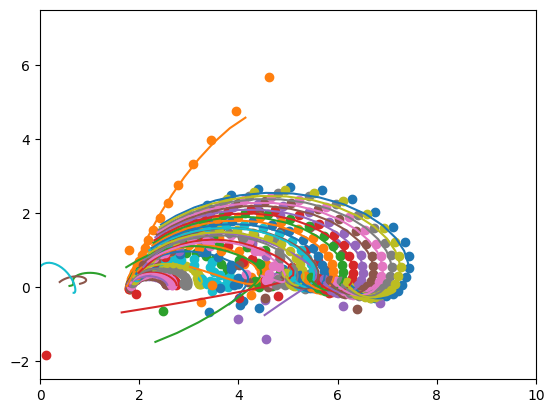

In [194]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
from matplotlib.transforms import Bbox


x_re = []
x_im = []
Electrode_Potential = []
Current = []
Current_min = []
Current_max = []

fig, (ax) = plt.subplots()
ax.set_xlim(0,10)
ax.set_ylim(-2.5,7.5)

for key in output.keys():



    cycle_output = output[key]

    ax.scatter(cycle_output['ReZ'],cycle_output['ImZ'])
    ax.plot(np.matmul(cycle_output['A_re'],cycle_output['x_re'])+cycle_output['R'],np.matmul(cycle_output['A_im'],cycle_output['x_im'])+cycle_output['f_m']*cycle_output['L'])


    x_re.append(cycle_output['x_re'])
    x_im.append(cycle_output['x_im'])
    Electrode_Potential.append(cycle_output['E'][-1])
    Current.append(np.mean(cycle_output['I']))
    Current_max.append(np.max(cycle_output['I']))
    Current_min.append(np.min(cycle_output['I']))

x_re = np.array(x_re).T
x_im = np.array(x_im).T
Electrode_Potential = np.array(Electrode_Potential)
Current = np.array(Current)
Current_max = np.array(Current_max)
Current_min = np.array(Current_min)






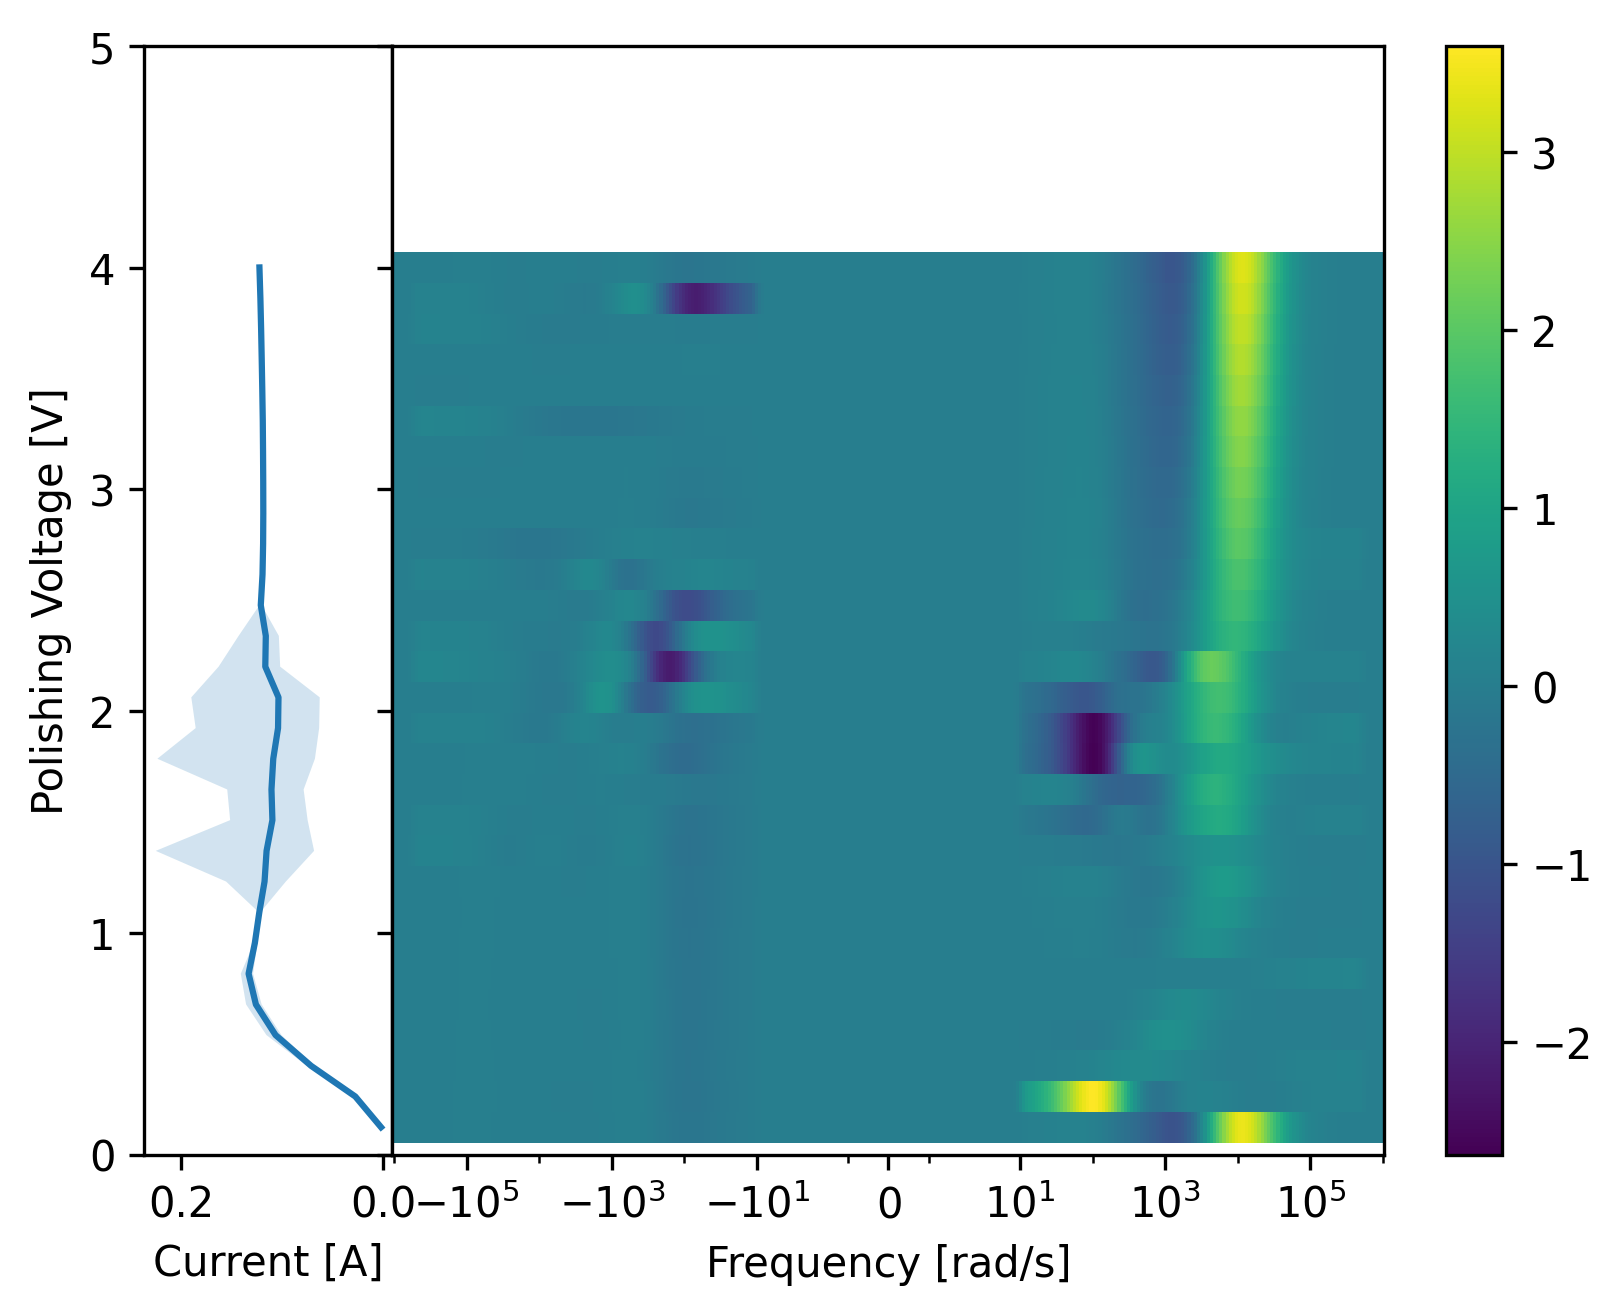

In [195]:
x_pos = (x_re + x_im)/2
x_neg = (x_re - x_im)/2
"""Plotting"""

# Plot gamma functions
#Params
plot_freq_min = 1e0
plot_freq_max = 1e6
plot_points_per_decade = 10


#Convert to log
log_plot_freq_min = np.log(plot_freq_min)
log_plot_freq_max = np.log(plot_freq_max)
plot_points = int(plot_points_per_decade*(log_plot_freq_max-log_plot_freq_min))

#Generate plotting frequencies
log_plot_freq = np.linspace(log_plot_freq_min,log_plot_freq_max,plot_points)

pos_plot_freq = np.exp(log_plot_freq)
plot_freq = np.concatenate((np.flip(-pos_plot_freq),pos_plot_freq))


gamma_pos = np.sum(x_pos[None,:,:]*Gaussian_Func(log_plot_freq[:,None,None]-log_f_n[None,:,None],gaussian_width),axis=1)
gamma_neg = np.sum(x_neg[None,:,:]*Gaussian_Func(log_plot_freq[:,None,None]-log_f_n[None,:,None],gaussian_width),axis=1)

gamma = np.concatenate((np.flip(gamma_neg),gamma_pos))

fig, (ax1, ax2) = plt.subplots(ncols=2,dpi=300,sharey=True,gridspec_kw={'width_ratios': [1, 5]})

X,Y = np.meshgrid(plot_freq,Electrode_Potential,indexing='ij')

mesh = ax2.pcolormesh(X,Y,gamma,shading='auto', cmap='viridis')
#mesh.set_norm(SymLogNorm(linthresh=1e0,vmin=0,vmax=100))
cbar = fig.colorbar(mesh)

ax2.set_xscale('symlog')
ax2.set_xlabel('Frequency [rad/s]')
ax2.set_xticks([-1e5,-1e3,-1e1,0,1e1,1e3,1e5])
ax2.set_ylim(0,5)

ax1.plot(Current/1000,Electrode_Potential)
ax1.fill_betweenx(Electrode_Potential, Current_min/1000, Current_max/1000, alpha = 0.2)
ax1.set_ylabel('Polishing Voltage [V]')
ax1.set_xlabel('Current [A]')
ax1.invert_xaxis()
# ax1.set_xticks([0.1,0.2])
ax1.set_yticks(np.arange(0,6,1))
# ax1.set_xlim(0.2,0)

fig.subplots_adjust(wspace = 0)